# Using Symptoms to Predict the Chest Pain Type of an Individual with Heart Disease
Dsci 100-006, Group 2 

By: Lauren Williams (40301228), Harmandeep Singh (80027824), Chloe de Weerdt (30733018), Skyler Tanahara (80279326) 


## Introduction

Heart disease, specifically Coronary artery disease is “a common heart condition that affects the major blood vessels that supply the heart muscle. Cholesterol deposits (plaques) in the heart arteries are usually the cause of coronary artery disease” (Heart Disease - Symptoms and Causes - Mayo Clinic, 2022). Chest pain is a common symptom of heart disease but it is also easy to misdiagnose as it proves to be a common side effect of many conditions and drugs. The ability to predict whether a patient’s chest pain is a precursor, likely putting them at risk for the disease, allows us to take appropriate preventative measures. How can we predict the type of chest pain characterized by heart disease using a patient’s cholesterol levels and maximum heart rate? 

Cholesterol in your body serves many crucial purposes, especially maintenance of cell membrane integrity. However, when cholesterol levels rise, they lead to atherosclerosis (plaque formation), which is a hallmark of heart disease. This is why cholesterol levels are an efficient way to characterize individuals with heart disease. Maximum heart rate (MHR), provides insight into a person’s physical health, activity levels, and cardiovascular fitness. Having better cardiovascular fitness is a great way to prevent the onset of heart disease, which is why a patient’s MHR can be used alongside cholesterol levels to assess their risk of heart disease. 
 


In [2]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)

options(repr.matrix.max.rows = 10)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.5.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0

── Conflicts ───────────────────────────────────────── tidymodels_conflic

In [3]:
library(readr)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

read_data <- read_csv(url, col_names = FALSE)

heart_data <- read_data |>

    mutate(chol = X5, sex = X2, cp = X3, thalach = X8) |>
    select(chol, sex, cp, thalach) |>
    mutate(sex = ifelse(sex == 1, "male", "female")) |>  
    mutate(cp = recode(cp, "1" = "typical angina", "2" = "atypical angina", "3" = "non-anginal pain", "4" = "asymptomatic"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chol,sex,cp,thalach
<dbl>,<chr>,<chr>,<dbl>
233,male,typical angina,150
286,male,asymptomatic,108
229,male,asymptomatic,129
250,male,non-anginal pain,187
204,female,atypical angina,172
⋮,⋮,⋮,⋮
264,male,typical angina,132
193,male,asymptomatic,141
131,male,asymptomatic,115


Tibble showing preview of selected columns of heart_data

## Preliminary exploratory data analysis:



In [4]:


col_count <- heart_data |>
            reframe(unique(chol)) |>
            nrow()
   
sex_count <- heart_data |>
            reframe(unique(sex)) |>
            nrow()

thalach_count <- heart_data |>
            reframe(unique(thalach)) |>
            nrow()

cp_count <- heart_data |>
            reframe(unique(cp)) |>
            nrow()

summary_table <- heart_data |>
    mutate("Rows with Missing Data" = sum(is.na(chol) | is.na(sex) | is.na(thalach) | is.na(cp))) |>
    mutate(sex = ifelse(sex == "male", 1, 2)) |>
    select(-cp) |>
    map_df(mean) |>
    mutate(sex1 = ifelse(sex > 1.5, "female", "male")) |>
    relocate(sex1, .after = thalach) |>
    mutate("Number of Sex Observations" = sex_count,
           "Number of Cholesterol Observations" = col_count, 
           "Number of Maximum Heart Rate Obersvations" = thalach_count,
           "Number of Chest Pain Type Observations" = cp_count) |>
    rename("Cholesterol Average" = chol, "Maximum Heart Rate Average" = thalach, "Sex Average" = sex1) |>
    select(-sex) 
    
    
    
summary_table

Cholesterol Average,Maximum Heart Rate Average,Sex Average,Rows with Missing Data,Number of Sex Observations,Number of Cholesterol Observations,Number of Maximum Heart Rate Obersvations,Number of Chest Pain Type Observations
<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<int>
246.6931,149.6073,male,0,2,152,91,4


Summary Table

    

## Methods:
Initially, after switching out our model that preicts sex based on age and cholesterol, we set out to make a graph that would predict the cholesterol level's range (chol) 
based on chest pain type (cp) and maximum heart rate (thalach). This idea turned out to be much less efficient than we were hoping since cp is categorical (has only 4 possible values), and cholesterol is not (has >100 different values that would need to be grouped into categories, ex: "100 - 200 mg/dl"). It made more sense to switch cholesterol to be one of the predictors and have chest pain type be the class, since this model would still be useful for mking predictions based on symptoms but would be much more polished.

In our final version of the model, the columns for Cholesterol levels "chol" and Maximum heart rate achived "thalach" were used to create a model that will predict the class of chest pain type "cp".

A scatterplot graph depicting "Predicting Chest pain type using Cholesterol levels and Maximum heart rate (separated by sex)" was generated from the training data. This graph is separated by the individual diagnosed with heart disease's sex using facet_wrap, and is colourcoded based on the class being predicted (Chest pain type (cp)). The predictors are "Cholesterol serum level im mg/dl (standardized)" on the x-axis, and "Maximum Heart rate (standardized)" on the y-axis.

For the data analysis we chose to test the accuracy of our model using the k-nearest neighbors algorithm. For the cross validation we used tune() and vfold, and were able to determine, using a cross-validation graph and table showing the metrics, that the number of neighbors with the highest likelihood of producing an accurate result would be 5. The linear cross-validation graph was generated to show the the number of neighbors (on the x-axis) and the accuracy (on the y-axis). 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



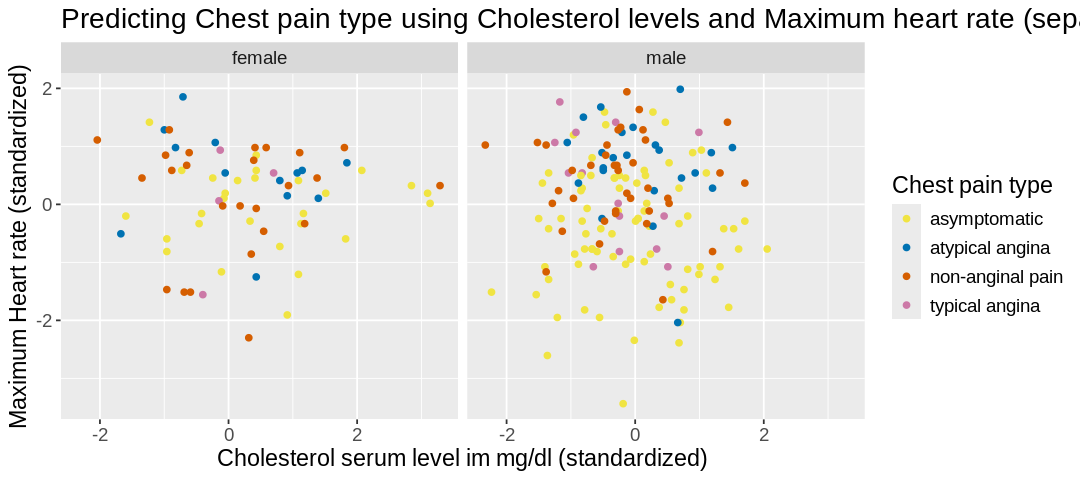

In [7]:

install.packages("themis")
library(themis)

set.seed(4321)

heart_data_recipe <- recipe(cp ~ thalach + chol + sex, data = heart_data) |>
                        step_scale(chol, thalach) |>
                        step_center(chol, thalach) #|> 
                        #step_upsample(sex, over_ratio = 1, skip = FALSE)  

heart_data_scaled <- heart_data_recipe |>
    prep() |> 
    bake(heart_data)

heart_split <- initial_split(heart_data_scaled, prop = 0.75, strata = cp)  
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

options(repr.plot.width = 9, repr.plot.height = 4)

heart_plot <- heart_train |>
    ggplot(aes(x = chol, y = thalach))+
        geom_point(aes(color = cp)) +
        facet_wrap(facets = vars(factor(sex))) +
        labs(x = "Cholesterol serum level im mg/dl (standardized)", y = "Maximum Heart rate (standardized)",
             color = "Chest pain type", 
             title = "Predicting Chest pain type using Cholesterol levels and Maximum heart rate (separated by sex)") +
        scale_colour_manual(values = c( "#F0E442", "#0072B2", "#D55E00", "#CC79A7")) +
        theme(text = element_text(size = 14)) 

heart_plot

## Data Analysis:

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4805195


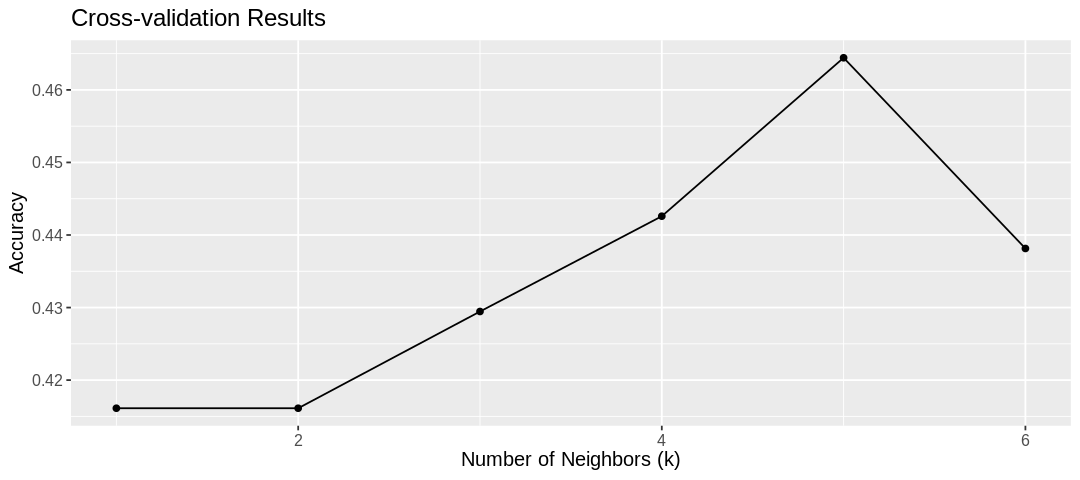

In [6]:
set.seed(4321)

heart_recipe <- recipe(cp ~ ., data = heart_train) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5, strata = cp)
vals <- tibble(neighbors = seq(from = 1, to = 6, by = 1))

knn_workflow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_vfold, grid = vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(knn_workflow, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (k)", y = "Accuracy", title = "Cross-validation Results") +
  theme(text = element_text(size = 12))
cross_val_plot

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
      add_recipe(heart_recipe) |>
      add_model(heart_spec) |>
      fit(data = heart_train)

heart_predictions <- predict(heart_fit,heart_test) |>
       bind_cols(heart_test) |>
       metrics(truth = cp, estimate = .pred_class) |>
       filter(.metric == "accuracy")
heart_predictions


## Expected Outcomes and Significance:

The graph titled "Predicting Chest pain type using Cholesterol levels and Maximum heart rate (separated by sex)" is showing Chest pain type with respect to different colors, using Cholesterol levels and Maximum heart rate. It is also separated by the individual diagnosed with heart disease’s sex. All data used in our analysis is from patients already diagnosed with heart disease. We chose these predictors because they had the highest correlation to each other because this would produce the most accurate results within a predictive model. We tested this by constructing and experimenting with different graphs (with different predictors) and comparing. Chest pain type is categorized into four different groups. Asymptomatic refers to individuals who have heart disease, but do not experience any symptoms. Non-Anginal refers to chest pain that is not related to heart disease. Typical Angina refers to chest pain with classic symptoms associated with heart disease. This includes a feeling of pressure, squeezing, or tightness in the chest, often radiating to the left arm, neck, or jaw. It is typically triggered by physical exertion or emotional stress and relieved by rest or medication like nitroglycerin. Lastly Atypical Angina is chest pain that does not follow the classic pattern of typical angina. Symptoms may include sharp or burning pain and can occur in areas other than the chest, such as the back or jaw. 

Initially when thinking about what relationships we would see, we thought higher cholesterol levels or maximum heart rates might be linked to atypical chest pain. We also thought that there could be differences in the type of chest pain experienced between males and females with heart disease. For instance, females might experience different patterns of chest pain compared to males, even with similar cholesterol levels and maximum heart rates. Both of these hypotheses nearly align with the results produced. In the model there is strong evidence supporting that higher max heart rate indicates that the individual would have atypical angina. There is little evidence to suggest the same conclusions can be drawn with respect to cholesterol level because the atypical data points (blue) are more spread across. This is consistent for almost all data points, therefore indicating max heart rate has the strongest association to the type of chest pain

. Our other hypothesis of the variation between male and female also has strong evidence to support it,  because we can see that the model shows concentration of different types of chest pain in different areas in the graph. For example non-anginal pain is more spread out in females (even with the difference in amount of data that is female vs male)Many cases of atypical angina present in the graph tend to appear alongside a higher max heart rate in men than women, though their range with respect to cholesterol is similar. Asymptomatic type cases are the most common chest pain type for both female and male individuals, and appear to be similarly distributed among cases from females and males, though, for the females, more outliers of this type appear towards the higher end of cholesterol level, and fewer data points extend as far towards the high or low end of the maximum heart rates observed in males. It is difficult to comment on any trends in typical angina type cases since there is such a small sample size.

In the Cross validation graph it can be seen that the number of nearest neighbors that produces the most accurate prediction model is 5, and the table above this graph shows that that accuracy is around 48%. This is not an ideal result, but with the basis of this report it could be useful to conduct further study by repeating the methods we have implemented on a larger, more recent dataset that would preferrably have a more even split of cases that are from male patients an female patients.d. 

These findings have significance in our world. Heart disease is a leading cause of death today and chest pain type plays a crucial role in identifying individuals at risk. With this dataset, individuals with certain cholesterol levels and post-exercise (situationally elevated) heart rates could use this , or others of its type,model to indicate the type of chest pain they are more likely to experience if they develop heart disease. Individuals would then gain insights into their potential symptoms and take proactive measures to monitor their health effectively, thus potentially preventing complications and serious cardiovascular events, such as heart attacks or strokes. Moreover, for individuals identified as asymptomatic based on their data profile (sex, max heart rate, cholesterol serum level), the model could offer guidance on the frequency of medical check-ups recommended to monitor their heart health. Overall the model we created, and its findings has an impact on understanding individuals potential for developing heart disease. As a population this model and others alike enables us to make informed decisions about their health, empowering them to take proactive steps towards prevention, early detection, and management of heart disease. Further questions could arise from this data analysis: Are there differences in these relationships between different demographic and clinical subgroups, therefore how accurate is this data analysis? How can treatment strategies be tailored to the specific needs of each gender?  


Citations: 

Heart disease - Symptoms and causes - Mayo Clinic. (2022, August 25). Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-203531



18
Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R., (1988). Heart Disease. UC Irvine.
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
